Saving RecipesAll.csv to RecipesAll.csv
User uploaded file "RecipesAll.csv" with length 2438897 bytes


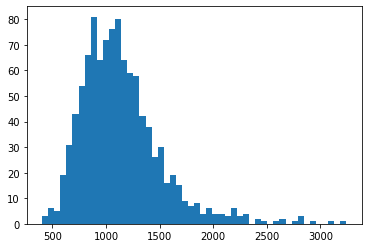

3244
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
7596


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import re
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
import io
recipes = pd.read_csv(io.BytesIO(uploaded['RecipesAll.csv']))

import matplotlib.pyplot as plt
recipes_lengths = []
recipes_text=[]
for i in range(len(recipes)) : 
    recipes_lengths.append(len(recipes.loc[i, "fulltext"]))
    recipes_text.append(recipes.loc[i, "fulltext"])
plt.hist(recipes_lengths, bins=50)
plt.show()
longest_rec=max(recipes_lengths)
print(longest_rec)
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
recipes['cleantext'] = recipes['fulltext'].apply(lambda x: word_tokenize(x))
result = [list(filter(lambda x: x not in string.punctuation, sentence)) for sentence in recipes['cleantext']]


data = result
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
total_words = len(tokenizer.word_index) + 1
print(total_words) 
input_sequences=[]
for line in data:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre'))
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


In [ ]:

outputnum=200
nodes=300
model = Sequential()
model.add(Embedding(total_words, outputnum, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(nodes), input_shape=(max_sequence_length-1,total_words)))
model.add(Dense(total_words/20))
model.add(Dense(total_words, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 572, 200)          1519200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1202400   
_________________________________________________________________
dense_2 (Dense)              (None, 379)               227779    
_________________________________________________________________
dense_3 (Dense)              (None, 7596)              2886480   
Total params: 5,835,859
Trainable params: 5,835,859
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate(next_words, seed_text):
    for n in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length - 1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                seed_text += " " + output_word
    return seed_text

seed_text = "Burger"
next_words = 500
test=generate(next_words, seed_text)
print(test)

Burger deliciously 348 12.4mg 12.4mg 932mg 932mg 100.5g 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 aside equivalent equivalent doubt cork 24.5mg 24.5mg 24.5mg 24.5mg set 24.5mg set famous famous 100.5g famous stretch 146.1mg folklore boiler boiler boiler boiler boiler boiler 295 77.4mg 1280 1280 1280 giblet cole colander colander colander colander fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten fasten faste

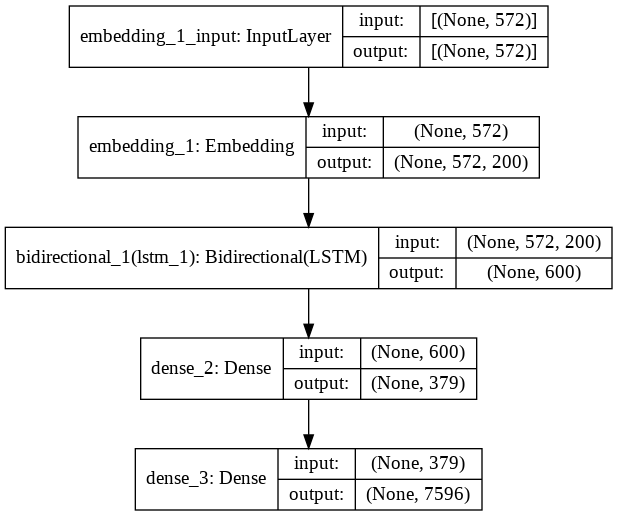

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/100
5118/5118 [==============================] - 700s 137ms/step - loss: 3.2562 - accuracy: 0.3835 - val_loss: 3.2453 - val_accuracy: 0.3996
Epoch 2/100
5118/5118 [==============================] - 700s 137ms/step - loss: 2.8597 - accuracy: 0.4247 - val_loss: 3.1936 - val_accuracy: 0.4181
Epoch 3/100
5118/5118 [==============================] - 697s 136ms/step - loss: 2.5454 - accuracy: 0.4591 - val_loss: 3.2222 - val_accuracy: 0.4253
Epoch 4/100
5118/5118 [==============================] - 699s 137ms/step - loss: 2.2243 - accuracy: 0.4945 - val_loss: 3.3630 - val_accuracy: 0.4219
Epoch 5/100
5118/5118 [==============================] - 698s 136ms/step - loss: 1.9056 - accuracy: 0.5404 - val_loss: 3.5723 - val_accuracy: 0.4183
Epoch 6/100
5118/5118 [==============================] - 699s 136ms/step - loss: 1.6074 - accuracy: 0.5922 - val_loss: 3.8311 - val_accuracy: 0.4089
Epoch 7/100
5118/5118 [==============================] - 699s 137ms/step - loss: 1.3669 - accuracy: 0.6384

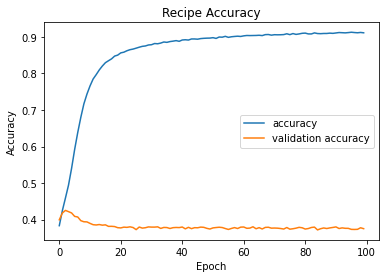

In [ ]:
history = model.fit(xs, ys, validation_split = 0.2, epochs=100, verbose=1)
name = "Optimized100ERecipe"
model_name = '%s.h5' % name
model.save(model_name, save_format='h5')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','validation accuracy'])
plt.title('Recipe Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


model = tf.keras.models.load_model('Optimized100ERecipe.h5')
seed_text = "Burger"
next_words = 500
test=generate(next_words, seed_text)
print(test)

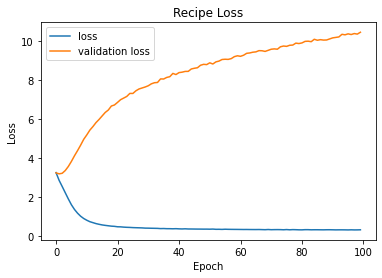

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Recipe Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()